In [1]:
import marimo as mo
import jax
import jax.numpy as jnp
import jax.random as jr
import numpyro
import numpyro.distributions as dist
import numpy as np
import arviz as az

import seaborn as sns
import matplotlib.pyplot as plt
import arviz_plots as azp

azp.style.use("arviz-vibrant")

/Users/curro/Documents/Dev/handbook-abc-jax/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#  ABC Importance sampling

## References

[ABC Samplers](https://doi.org/10.48550/arXiv.1802.09650)

## Algorithm

**Inputs:**
- Prior distribution distribution $\pi(\theta)$
- Procedure for generating data under the model $p(y|\theta)$
- Proposal density $g(\theta)$ with $g(\theta) > 0$ if $\pi(\theta|y_{obs}) > 0$
- Number of samples $N > 0$
- Kernel function $K_h(u)$ with bandwidth $h > 0$
- Summary statistic $s = S(y)$
- Observed summary statistic $s_{obs} = S(y_{obs})$

**Algorithm:**

For $i = 1, \ldots, N$:
1. Generate $\theta^{(i)} \sim g(\theta)$ from the proposal density
2. Generate $y \sim p(y|\theta^{(i)})$ from the simulator
3. Compute summary statistic $s = S(y)$
4. Compute weight $w=$

   $\displaystyle \frac{K_h(\|s - s_{obs}\|) \pi(\theta^{(i)})}{g(\theta^{(i)})}$


**Output:**
- A set of weighted samples $\{(\theta^{(i)}, w^{(i)})\}_{i=1}^N$ that can be used to approximate the posterior distribution $\pi(\theta|y_{obs})$.

In [2]:
def gaussian_kernel(u):
    """Gaussian kernel: 1/√(2π) * exp(-u²/2)"""
    return (1 / jnp.sqrt(2 * jnp.pi)) * jnp.exp(-0.5 * u**2)

def abc_importance_sampling(
    key,
    log_prior_density,
    log_proposal_density,
    proposal_sample,
    simulator,
    num_candidates,
    s_obs,
    distance,
    summary_stat=jax.nn.identity,
    kernel=gaussian_kernel,
    h=1.0,
):
    """
    ABC importance sampling sampling strategy.

    Args:
        key: JAX random key
        log_prior_density: function log π(θ) computing log prior density
        log_proposal_density: function log g(θ) computing log proposal density
        proposal_sample: function to sample from proposal (key, n) -> dict of arrays
        simulator: function p(y|θ) to sample data (key, params) -> y
        num_candidates: number of candidates to generate
        s_obs: observed summary statistics
        summary_stat: function S(y) computing summary statistics
        distance: distance function for summary statistics
        kernel: kernel function Kh(u)
        h: bandwidth parameter for kernel

    Returns:
        az.InferenceData with resampled parameters, expected posterior samples, and effective sample size.
    """
    key, key_propose, key_likelihood, key_accept = jr.split(key, 4)

    # Step 1: Generate candidates from proposal (dict of arrays)
    theta_candidates = proposal_sample(key_propose, num_candidates)

    # Step 2 & 3: Generate data and compute summary statistics
    keys_likelihood = jr.split(key_likelihood, num_candidates)
    y_samples = jax.vmap(simulator)(keys_likelihood, theta_candidates)
    s_samples = jax.vmap(lambda y: jnp.atleast_1d(summary_stat(y)))(y_samples)
    s_obs_vec = jnp.atleast_1d(s_obs)

    # Step 4: Compute acceptance probabilities
    distances = distance(s_samples, s_obs_vec)
    kernel_values = jax.vmap(kernel)(distances / h)

    log_prior_values = jax.vmap(log_prior_density)(theta_candidates)
    log_proposal_values = jax.vmap(log_proposal_density)(theta_candidates)

    # Accept with probability: Kh(||s - s_obs||) * π(θ) / (K * g(θ))
    log_probs = jnp.log(kernel_values) + log_prior_values - log_proposal_values
    logweights = log_probs - jax.scipy.special.logsumexp(log_probs)
    weights = jnp.exp(logweights)

    # Compute ESS
    ess = 1 / jnp.sum(weights**2)
    # Compute expected posterior samples (weighted average)
    expected_posterior = jax.tree.map(
        lambda theta: jnp.sum(weights[:, None] * theta, axis=0), theta_candidates
    )
    # Resample parameters according to weights (default to ESS number of samples)
    num_resampled = int(jnp.max(jnp.array([1, jnp.round(ess)])))
    resampled_indices = jr.choice(
        key_accept, num_candidates, shape=(num_resampled,), p=weights
    )
    accepted_samples = jax.tree.map(
        lambda arr: arr[resampled_indices], theta_candidates
    )

    # ArviZ expects shape (chains, draws, *param_shape)
    posterior_dict = {
        k: np.asarray(v)[np.newaxis, :] for k, v in accepted_samples.items()
    }
    idata = az.from_dict(posterior=posterior_dict)
    idata.add_groups(
        {
            "prior": {
                k: np.asarray(v)[np.newaxis, :] for k, v in theta_candidates.items()
            }
        }
    )
    return idata, expected_posterior, ess

## Example (from the book)

Suppose the model is specified as $y_1, \dots, y_{50} \sim N(\theta, 1)$, with uniform prior $\theta \sim U(-5, 5)$.

In [3]:
theta_true = 2.5
observed_y = dist.Normal(theta_true, 1).sample(jr.key(1), (50,))
observed_y

Array([2.345563  , 2.5847073 , 2.3640194 , 2.3449638 , 3.7666674 ,
       2.6482975 , 4.6415606 , 3.502674  , 2.209664  , 2.8583448 ,
       1.7920727 , 2.2544448 , 3.3855824 , 3.286119  , 3.3889272 ,
       3.0493255 , 3.4658084 , 0.70281506, 3.360454  , 0.8823941 ,
       2.4400551 , 0.99452674, 1.4992719 , 3.1435654 , 0.8084295 ,
       3.0178628 , 3.2885132 , 1.3877132 , 2.0938528 , 1.3641559 ,
       3.613792  , 2.1677556 , 3.005773  , 4.521299  , 2.516674  ,
       4.6386566 , 5.1084757 , 1.2212428 , 3.43114   , 3.4858668 ,
       3.6210191 , 2.5874965 , 4.063922  , 2.7328095 , 3.3074763 ,
       3.0017173 , 3.2227018 , 3.3612227 , 3.760047  , 3.3339958 ],      dtype=float32)

## Rejection (with sufficient summary statistics)

In [4]:
# Define prior distribution
prior = dist.Uniform(-5, 5)
# Often, we use the prior as the proposal distribution
log_prior_density = lambda params: prior.log_prob(params["theta"])
log_proposal_density = lambda params: prior.log_prob(params["theta"])
proposal_sample = lambda key, n: {"theta": prior.sample(key, (n,))}
# Sufficient summary statistic
summary_stat = lambda y: jnp.mean(y)
# Bandwidth for kernel and number of candidates to generate
num_candidates = 50_000

Often, the simulator function cannot be JIT compiled and it's expensive to evaluate. Such code must be wrapped with `pure_callback`.

In [5]:
def black_box_simulator(key, params):
    import numpy as np

    # Convert JAX random key to numpy seed by extracting bytes
    # The key is a JAX array, extract first integer from it
    key_array = np.asarray(key)
    seed = int(key_array.view(np.uint32).flat[0])
    np.random.seed(seed)
    n_obs = 50
    # Extract scalar value from params["theta"] (handles both scalars and 1D arrays)
    theta_val = float(np.squeeze(np.asarray(params["theta"])))
    y = np.random.normal(theta_val, 1.0, n_obs)
    return jnp.array(y)

# Wrap with pure_callback to make it compatible with JAX transformations
# The callback is called with arguments inside a vmap loop
def simulator(key, params):
    return jax.pure_callback(
        black_box_simulator,
        jax.ShapeDtypeStruct(shape=(50,), dtype=jnp.float32),
        key,
        params,
        vmap_method="sequential",
    )

In [6]:
# Compute observed summary statistics
s_obs = jnp.atleast_1d(summary_stat(observed_y))
posterior_abc_sf, expected_sf, ess_sf = abc_importance_sampling(
    key=jr.key(0),  # Set seed for reproducibility
    log_prior_density=log_prior_density,
    log_proposal_density=log_proposal_density,
    proposal_sample=proposal_sample,
    simulator=simulator,
    num_candidates=num_candidates,
    s_obs=s_obs,
    # Euclidean distance for summary statistics
    distance=lambda s, s_obs: jnp.linalg.norm(s - s_obs, axis=-1),
    summary_stat=summary_stat,
    kernel=gaussian_kernel,
    h=0.1,
)
print(f"Effective Sample Size (ESS): {ess_sf:.2f}")

Effective Sample Size (ESS): 1755.38


In [7]:
az.summary(posterior_abc_sf)

arviz - WARNING - Shape validation failed: input_shape: (1, 1755), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,2.837,0.174,2.524,3.154,0.004,0.003,1762.0,1618.0,NaN


<Axes: ylabel='Density'>

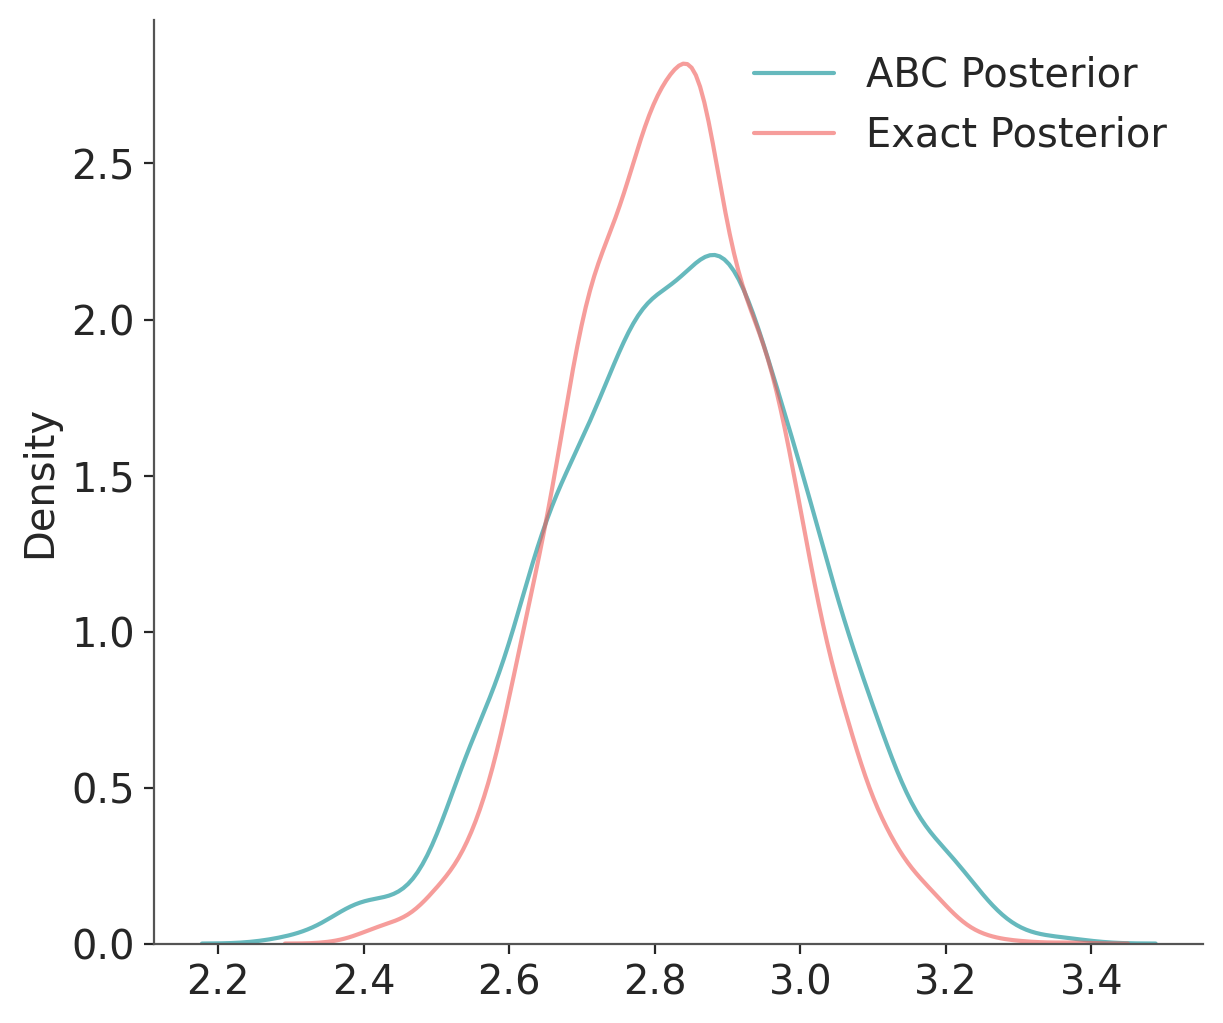

In [8]:
sns.kdeplot(
    posterior_abc_sf.posterior["theta"].values.flatten(),
    alpha=0.6,
    color="C0",
    label="ABC Posterior",
)
# Ground truth posterior (conjugate normal)
posterior_exact = dist.Normal(observed_y.mean(), 1 / jnp.sqrt(50)).sample(
    jr.key(1), (5000,)
)
posterior_exact = posterior_exact[
    (posterior_exact >= -5) & (posterior_exact <= 5)
]  # Truncate to match uniform prior support
sns.kdeplot(posterior_exact, alpha=0.6, color="C1", label="Exact Posterior")
plt.legend()
plt.gca()

Often, sufficient summary statistics are not available. One popular distance metric between the observed and simulated data is the Wasserstein distance:

In [9]:
def wasserstein_distance(a, b):
    from scipy.stats import wasserstein_distance

    return jax.pure_callback(
        lambda a, b: jnp.array([wasserstein_distance(x, b) for x in a]),
        jax.ShapeDtypeStruct((a.shape[0],), jnp.float32),
        a,
        b,
        vmap_method="sequential",
    )

In [10]:
posterior_abc_ws, expected_ws, ess_ws = abc_importance_sampling(
    key=jr.key(0),  # Set seed for reproducibility
    log_prior_density=log_prior_density,
    log_proposal_density=log_proposal_density,
    proposal_sample=proposal_sample,
    simulator=simulator,
    num_candidates=num_candidates,
    s_obs=observed_y,  # Use raw observed data
    kernel=gaussian_kernel,
    distance=wasserstein_distance,
    h=0.2,
)
print(f"Effective Sample Size (ESS): {ess_ws:.2f}")

Effective Sample Size (ESS): 3682.27


In [11]:
az.summary(posterior_abc_ws)

arviz - WARNING - Shape validation failed: input_shape: (1, 3682), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,2.841,0.26,2.318,3.292,0.004,0.003,3373.0,3653.0,NaN


<Axes: ylabel='Density'>

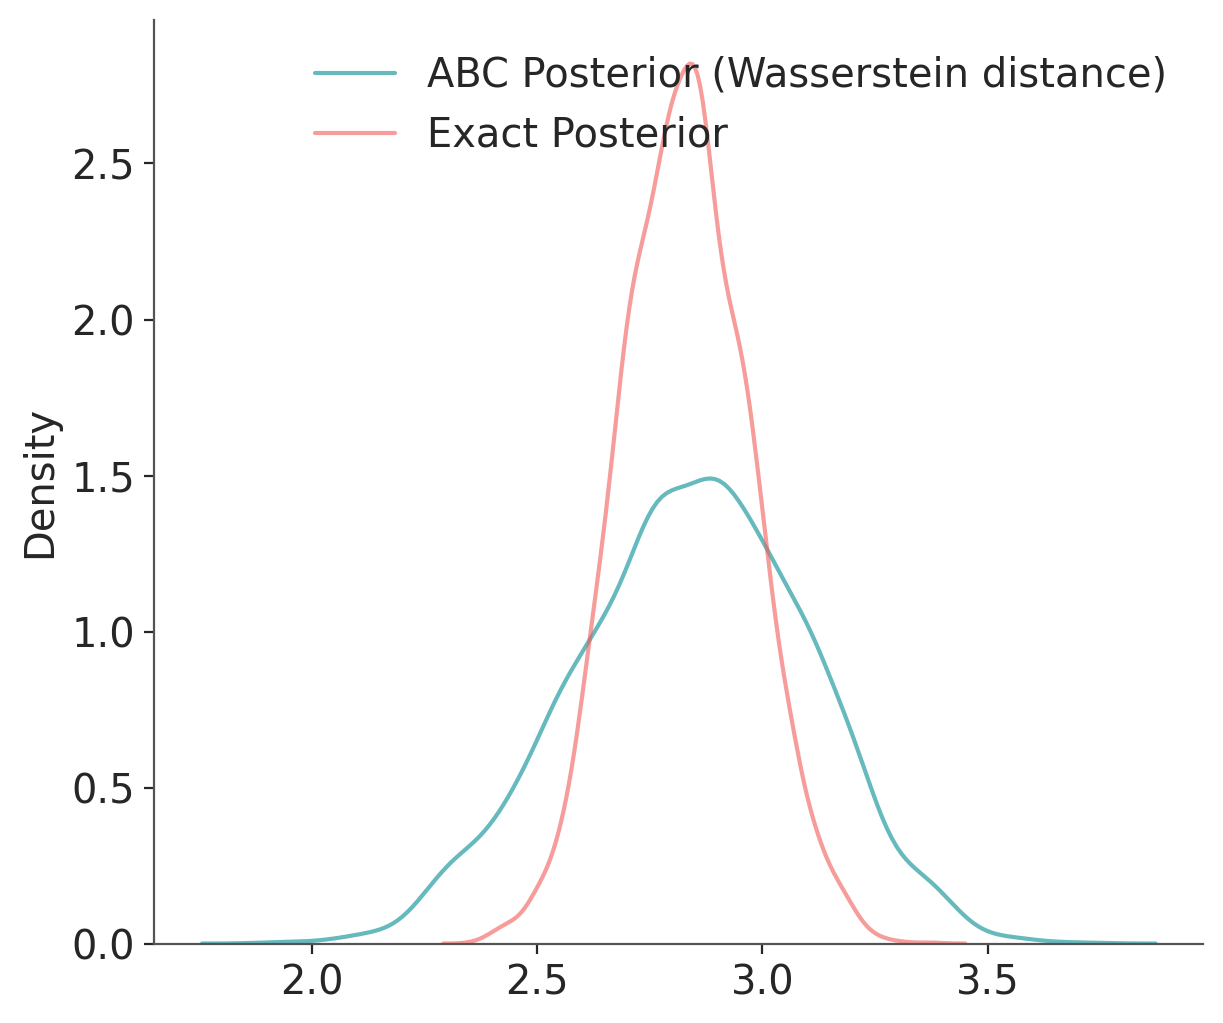

In [12]:
sns.kdeplot(
    posterior_abc_ws.posterior["theta"].values.flatten(),
    alpha=0.6,
    color="C0",
    label="ABC Posterior (Wasserstein distance)",
)
# Ground truth posterior (conjugate normal)
sns.kdeplot(posterior_exact, alpha=0.6, color="C1", label="Exact Posterior")
plt.legend()
plt.gca()